In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
### Set up the pauli ops
I,X,Y,Z = np.matrix([[1,0],[0,1]]),np.matrix([[0,1],[1,0]]),np.matrix([[0,-1j],[1j,0]]),np.matrix([[1,0],[0,-1]])
[X0,Y0,Z0] = [np.kron(op,I) for op in [X,Y,Z]]
[X1,Y1,Z1] = [np.kron(I,op) for op in [X,Y,Z]]

a =  np.matrix([[0,1],[0,0]])
a0,a1 = np.kron(a,I),np.kron(I,a)

In [3]:
from scipy.linalg import expm
def evolve(pulses, dt, H0, H_ops):
    """
    Compute the operator associated with a set of pulses
    
    (List[List[Float]]) pulses: The pulses. Each element should have length equal length
    (Float) dt: duration of each pulse
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    """
    U = np.identity(len(H0))
    for i in range(len(pulses[0])): 
        H = H0
        for k in range(len(pulses)):
            H = H + pulses[k][i] * H_ops[k]
        U=expm(-1j * dt * H) @ U
    return U
def getFidelity(dt, H0, H_ops,target):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        ω = coeffs[0] ###Drift frequency
        ϕ0,ϕ1 = coeffs[1],coeffs[2] ###Drive phases 
        [ε0,ε1] = np.split(coeffs[3:len(coeffs)-1],2) ###Drive amplitude
        N = len(ε1) ###Discretization length
        J = coeffs[len(coeffs)-1]
        
        drift_pulse = [ω] * N
        drive_pulses = [np.exp(1j * ϕ0)*ε0,np.exp(-1j * ϕ0)*ε0,np.exp(1j * ϕ1)*ε1,np.exp(-1j * ϕ1)*ε1]
        interaction_pulse = [J] * N 
        
        pulses = [drift_pulse]+drive_pulses+[interaction_pulse]
        U = evolve(pulses, dt, H0, H_ops)
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  -1 * fidelity 
    return loss 

In [4]:
import scipy
###Control and drift
"""
From left to right
    - Frequency controlled drift
    - Drive controls
    - Interaction Coupling
"""
H_ops = [a0.T @ a0 + a1.T @ a1, a0,a0.T,a1,a1.T, a0.T @ a1 + a0 @ a1.T]
H0 = np.matrix(np.zeros((4,4)))
CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

u0 = np.random.rand(2* N + 4 ) * 2 * np.pi * 0.05 #make a random array to start out
u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=CNOT)
                    ,x0=u0
                 )
print("CNOT Fidelity: "+str(-1 * result.fun))


CNOT Fidelity: 0.9999999999688395


In [5]:
###The parameterized lookup table we want
def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [6]:
T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

coefficients = []
fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.zeros(2* N + 4)
    if(theta == 0):
        u0 = np.random.rand(2* N + 4)  * 2 * np.pi * 0.05 #make a random array to start out
        u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    else:
        u0 = coefficients[len(coefficients)-1] #If we have a pulse, use the most recent one
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                    ,x0=u0
                 )
    coefficients.append(result.x)
    fidelities.append(result.fun)
    print("Angle "+str(theta)+" completed with fidelity "+str(-1 * result.fun))

Angle 0.0 completed with fidelity 0.9999999675050796
Angle 0.3306939635357677 completed with fidelity 0.9999999847207979
Angle 0.6613879270715354 completed with fidelity 0.9999999515839514
Angle 0.992081890607303 completed with fidelity 0.9999999997035218
Angle 1.3227758541430708 completed with fidelity 0.999999999902554
Angle 1.6534698176788385 completed with fidelity 0.9999999994056348
Angle 1.984163781214606 completed with fidelity 0.9999999988678582
Angle 2.3148577447503738 completed with fidelity 0.9999999971086684
Angle 2.6455517082861415 completed with fidelity 0.9999999987217665
Angle 2.9762456718219092 completed with fidelity 0.9999999996956329
Angle 3.306939635357677 completed with fidelity 0.9999999999370638
Angle 3.6376335988934447 completed with fidelity 0.9999999998035809
Angle 3.968327562429212 completed with fidelity 0.9999999996440817
Angle 4.29902152596498 completed with fidelity 0.9999999997675775
Angle 4.6297154895007475 completed with fidelity 0.9999999994841673
An

In [7]:
coefficients = np.array(coefficients)
def interpolate(theta,x,coefficients):
    coeffs = np.zeros(2* N + 4) 
    for i in range(2* N + 4):
        coeffs[i]=np.interp(x=theta,xp= x,fp=coefficients.T[i])
    return coeffs

In [8]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,np.linspace(0,2*np.pi,20),coefficients)))


Text(0, 0.5, 'fidelity')

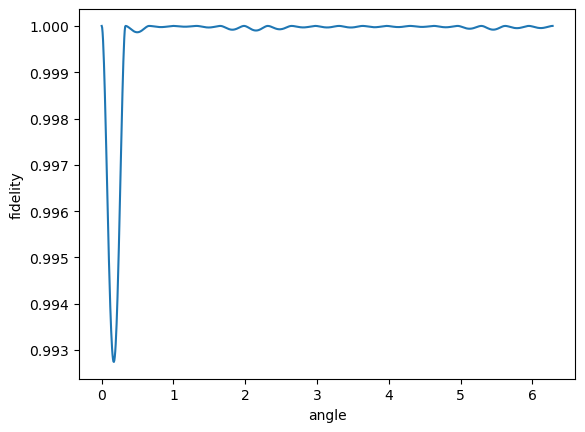

In [9]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [10]:
thetac = min(x, key = lambda v : y[list(x).index(v)])
print("Problem Angle: "+str(thetac))

Problem Angle: 0.16981581911296179


In [11]:
old_starter = coefficients[0]
new_coefficients = []
new_fidelities = []
problem_thetas = [thetac]
for _ in range(10):
    new_coefficients = []
    new_fidelities = []
    print("------------")
    print("Iteration: "+str(_))
    print("------------")
    theta_list = list(np.linspace(0,2*np.pi,20))+problem_thetas
    theta_list.sort()
    for theta in theta_list:
        u0 = np.zeros(2* N + 4)
        if(theta==0):
            u0 = old_starter
        else:
            u0 = new_coefficients[len(new_coefficients)-1]
        result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                            ,x0=u0
                         )
        new_coefficients.append(result.x)
        new_fidelities.append(-1*result.fun)
        print("------------")
        print("Angle "+str(theta))
        print("Loss "+str(result.fun))
        f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
        print("Fidelity "+str(f))
        print("------------")
    old_starter=new_coefficients[0]
    x=np.linspace(0,2*np.pi,1000)
    y=[]
    new_coefficients=np.array(new_coefficients)
    for i in x:
        y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,theta_list,new_coefficients)))
    thetac = min(x, key = lambda v : y[list(x).index(v)])
    print("Problem Angle: "+str(thetac))
    problem_thetas.append(thetac)



------------
Iteration: 0
------------
------------
Angle 0.0
Loss -0.9999999675050796
Fidelity 0.9999999675050796
------------
------------
Angle 0.16981581911296179
Loss -0.9999999990407592
Fidelity 0.9999999990407592
------------
------------
Angle 0.3306939635357677
Loss -0.9999999773841182
Fidelity 0.9999999773841182
------------
------------
Angle 0.6613879270715354
Loss -0.999999953744408
Fidelity 0.999999953744408
------------
------------
Angle 0.992081890607303
Loss -0.9999999999900514
Fidelity 0.9999999999900514
------------
------------
Angle 1.3227758541430708
Loss -0.9999999999570106
Fidelity 0.9999999999570106
------------
------------
Angle 1.6534698176788385
Loss -0.9999999994571136
Fidelity 0.9999999994571136
------------
------------
Angle 1.984163781214606
Loss -0.999999994260581
Fidelity 0.999999994260581
------------
------------
Angle 2.3148577447503738
Loss -0.9999999999795104
Fidelity 0.9999999999795104
------------
------------
Angle 2.6455517082861415
Loss -0

------------
Angle 2.9762456718219092
Loss -0.999999999998945
Fidelity 0.999999999998945
------------
------------
Angle 3.306939635357677
Loss -0.9999999808688032
Fidelity 0.9999999808688032
------------
------------
Angle 3.6376335988934447
Loss -0.9999999995760579
Fidelity 0.9999999995760579
------------
------------
Angle 3.968327562429212
Loss -0.9999999998448871
Fidelity 0.9999999998448871
------------
------------
Angle 4.29902152596498
Loss -0.9999999999127254
Fidelity 0.9999999999127254
------------
------------
Angle 4.6297154895007475
Loss -0.9999999999099787
Fidelity 0.9999999999099787
------------
------------
Angle 4.960409453036515
Loss -0.9999999999236172
Fidelity 0.9999999999236172
------------
------------
Angle 5.291103416572283
Loss -0.9999999987048511
Fidelity 0.9999999987048511
------------
------------
Angle 5.621797380108051
Loss -0.9999999999092509
Fidelity 0.9999999999092509
------------
------------
Angle 5.9524913436438185
Loss -0.9999999631493727
Fidelity 0

------------
Angle 2.9762456718219092
Loss -0.9999999997978527
Fidelity 0.9999999997978527
------------
------------
Angle 3.306939635357677
Loss -0.9999999998581233
Fidelity 0.9999999998581233
------------
------------
Angle 3.6376335988934447
Loss -0.9999999993871299
Fidelity 0.9999999993871299
------------
------------
Angle 3.968327562429212
Loss -0.9999999995526117
Fidelity 0.9999999995526117
------------
------------
Angle 4.29902152596498
Loss -0.9999999999647842
Fidelity 0.9999999999647842
------------
------------
Angle 4.6297154895007475
Loss -0.9999999994640103
Fidelity 0.9999999994640103
------------
------------
Angle 4.960409453036515
Loss -0.9999999993101413
Fidelity 0.9999999993101413
------------
------------
Angle 5.291103416572283
Loss -0.9999999984410322
Fidelity 0.9999999984410322
------------
------------
Angle 5.621797380108051
Loss -0.9999999999783841
Fidelity 0.9999999999783841
------------
------------
Angle 5.9524913436438185
Loss -0.9999999999206434
Fidelity

------------
Angle 1.3227758541430708
Loss -0.9999999994378748
Fidelity 0.9999999994378748
------------
------------
Angle 1.6534698176788385
Loss -0.9999999995161594
Fidelity 0.9999999995161594
------------
------------
Angle 1.8176582119868872
Loss -0.9999999999026047
Fidelity 0.9999999999026047
------------
------------
Angle 1.984163781214606
Loss -0.9999999999802911
Fidelity 0.9999999999802911
------------
------------
Angle 2.1510003754308493
Loss -0.9999999999849214
Fidelity 0.9999999999849214
------------
------------
Angle 2.3148577447503738
Loss -0.9999999999952769
Fidelity 0.9999999999952769
------------
------------
Angle 2.4780530640928498
Loss -0.9999999999967211
Fidelity 0.9999999999967211
------------
------------
Angle 2.6455517082861415
Loss -0.9999999996986386
Fidelity 0.9999999996986386
------------
------------
Angle 2.9762456718219092
Loss -0.9999999999241446
Fidelity 0.9999999999241446
------------
------------
Angle 3.306939635357677
Loss -0.9999999997047915
Fid

In [12]:
new_coefficients=np.array(new_coefficients)
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,theta_list,new_coefficients)))

Text(0, 0.5, 'fidelity')

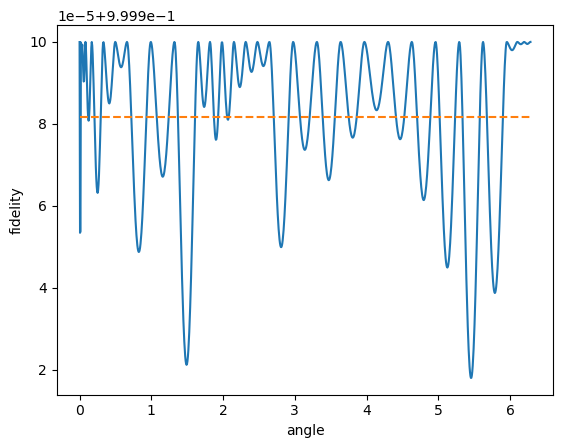

In [13]:
plt.plot(x,y)
plt.plot(x,[np.mean(y)]*len(x),'--')
plt.xlabel("angle")
plt.ylabel("fidelity")

In [14]:
print("Mean Fidelity: "+str(np.mean(y)))
print("Max Fidelity: "+str(np.max(y)))
print("Min Fidelity: "+str(np.min(y)))
print("Largest Amplitude: "+str(np.max(np.abs(new_coefficients))))

Mean Fidelity: 0.999981650901522
Max Fidelity: 0.9999999999967211
Min Fidelity: 0.999918034422286
Largest Amplitude: 3.010919647420639
